# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import pandas as pd
from numba import jit, njit, prange

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3, SampleModel4
from dissipationtheory.dissipation9b import SampleModel3Jit, SampleModel4Jit, integrand3jit, K_jit, Kmetal_jit

In [3]:
from dissipationtheory.dissipation9c import disentangle, compare
from dissipationtheory.dissipation9c import Cmatrix_jit, KmatrixIV_jit, inputs3, integrand3jitfast, inputsIII, KmatrixIII_jit

In [4]:
from dissipationtheory.dissipation9d import twodimCobject

In [5]:
from dissipationtheory.capacitance import Csphere, CsphereOverSemi

In [6]:
THIS = 'dissipation-theory--Study-54--'
figs = {}
obj = {}
df = {}

# Sample III and Sample IV test objects

In [7]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(30, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm')
)

In [8]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)
sample3_jit = SampleModel3Jit(**sample3.args())

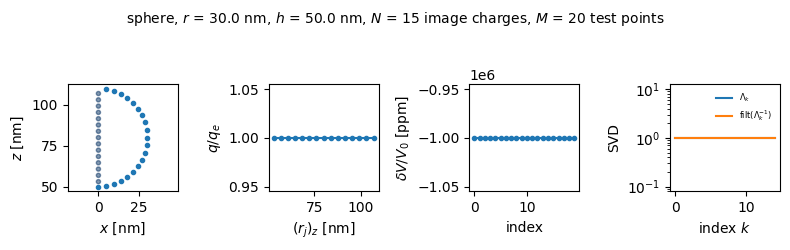

In [9]:
obj['III'] = twodimCobject(sample3_jit)

params = {'h': ureg.Quantity(50, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['III'].addsphere(**params)
_ = obj['III'].plot()

In [10]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(100, 'nm')
)
sample4_jit = SampleModel4Jit(**sample4.args())

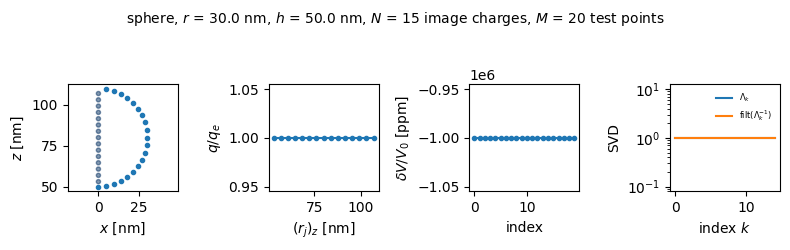

In [11]:
obj['IV'] = twodimCobject(sample4_jit)

params = {'h': ureg.Quantity(50, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IV'].addsphere(**params)
_ = obj['IV'].plot()

# Explore creating the $G_0$ and $K_n$ matrices

Distances in meters, not nanometers.

In [12]:
rj = obj['IV'].rj * 1e-9
rk = obj['IV'].rk * 1e-9

Normalized distances to fed to the Coulomb matrix function.

In [13]:
Rj = rj / obj['IV'].sample.z_r
Rk = rk / obj['IV'].sample.z_r

In [14]:
%%timeit
Cmat = Cmatrix_jit(Rj, Rk)

181 μs ± 40.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
Cmat = Cmatrix_jit(Rj, Rk)
Cmat[0]

array([33.33333333, 14.58333333,  9.33333333,  6.8627451 ,  5.42635659,
        4.48717949,  3.82513661,  3.33333333,  2.9535865 ,  2.65151515,
        2.40549828,  2.20125786,  2.02898551,  1.88172043,  1.75438596])

In [16]:
%%timeit
K0, K1, K2 = KmatrixIV_jit(obj['IV'].sample, rj, rk)

263 μs ± 27.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
K0, K1, K2 = KmatrixIV_jit(obj['IV'].sample, rj, rk)
K0[0]

array([0.97087379-0.j, 0.93582888-0.j, 0.90322581-0.j, 0.87281796-0.j,
       0.84439083-0.j, 0.81775701-0.j, 0.79275198-0.j, 0.76923077-0.j,
       0.7470651 -0.j, 0.72614108-0.j, 0.70635721-0.j, 0.68762279-0.j,
       0.66985646-0.j, 0.65298507-0.j, 0.63694268-0.j])

A baseline calculation of the $K_n$ vectors for just one pair of points.

In [18]:
v1r = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[0], rk[0])) 
v2r = disentangle(Kmetal_jit(sample4_jit, rj[0], rk[0])) 

In [19]:
compare(v1r,v2r)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8784531 +0.9708738 -1.1e-01 -10.521
1 -0.0004521 -0.0000000 +1.0e+00 +100.000
2 +0.8529024 +0.9425959 -1.1e-01 -10.516
3 -0.0003932 +0.0000000 +1.0e+00 +100.000
4 +1.6561775 +1.8302833 -1.1e-01 -10.513
5 -0.0006716 -0.0000000 +1.0e+00 +100.000


Now compute the full $K_n$ matrices. First for a semiconductor

In [20]:
%%timeit
K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, 1.0e5, rj, rk))

4.96 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, 1.0e5, rj, rk))
v1 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))
compare(v1r,v1)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8784531 +0.8784531 +2.0e-08 +0.000
1 -0.0004521 -0.0004521 -1.2e-05 -0.001
2 +0.8529024 +0.8529022 +2.3e-07 +0.000
3 -0.0003932 -0.0003932 -1.4e-06 -0.000
4 +1.6561775 +1.6561772 +1.4e-07 +0.000
5 -0.0006716 -0.0006713 +5.1e-04 +0.051


then for a metal

In [22]:
K0, K1, K2 = KmatrixIV_jit(sample4_jit, rj, rk)
v2 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))
compare(v2r,v2)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.9708738 +0.9708738 +0.0e+00 +0.000
1 -0.0000000 -0.0000000 +nan +nan
2 +0.9425959 +0.9425959 +0.0e+00 +0.000
3 +0.0000000 +0.0000000 +nan +nan
4 +1.8302833 +1.8302833 +0.0e+00 +0.000
5 -0.0000000 -0.0000000 +nan +nan


/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation9c.py:20: RuntimeWarning: invalid value encountered in divide
  epsilon_rel = (a-b) / a
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation9c.py:21: RuntimeWarning: invalid value encountered in divide
  epsilon_pct = 100 * (a-b) / a


The $K_n$ values at a representative point nearest the sample agree with our prior code.  \
For a metal the agreement is quantitative.  \
For the semiconductor, the agreement is better than 1 ppm for the real parts.

# Show that `KmatrixIV_jit` and `KmatrixIII_jit` produce the expected image-charge potential

## Metallic sample (Type IV)

In [202]:
def IV_vs_z(z, zr):

    rj = np.array([np.zeros_like(z), np.zeros_like(z), z]).T

    sample4 = SampleModel4(
        cantilever = cantilever,
        z_r = ureg.Quantity(zr, 'nm')
    )
    sample4_jit = SampleModel4Jit(**sample4.args())
        
    K0, K1, K2 = KmatrixIV_jit(sample4_jit, rj, rj)

    Y = np.diag(K0).real / (1e9 * sample4_jit.z_r)
    Z = z / sample4_jit.z_r

    fig = plt.figure(figsize=(3.50, 2.5))
    plt.semilogx(z/1e-9, Y, '.')
    plt.semilogx(z/1e-9, 1/(2 * 1e9 * z), '-')
    plt.xlabel('distance $z$ [nm]')
    plt.ylabel('$K_0/z_{\mathrm{r}}$ [1/nm]')
    
    fig.tight_layout()
    
    return fig, sample4_jit, rj 

We see the expected normalized image potential over a metal.

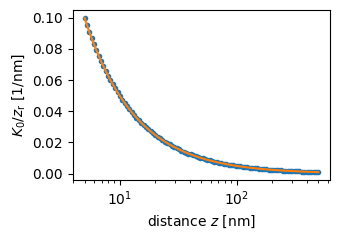

In [203]:
z = 1.0e-9 * np.logspace(np.log10(5), np.log10(500), 100)
_, _, _ = IV_vs_z(z, 100)

The image potential is the same even if you change the scaling parameter.

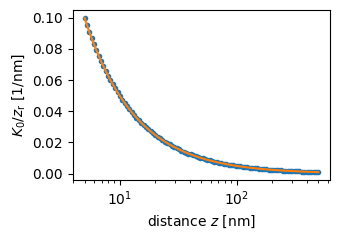

In [204]:
_, _, _ = IV_vs_z(z, 10)

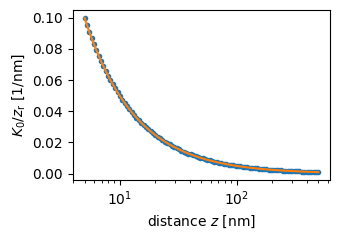

In [205]:
_, _, _ = IV_vs_z(z, 3)

**$K_0$ computed from `KmatrixIV_jit` is giving the expected image potential, independent of the scaling parameter $z_{\mathrm{r}}$.**

## Metallic sample (Type III)

In [206]:
def III_vs_z(z, zr):

    rj = np.array([np.zeros_like(z), np.zeros_like(z), z]).T

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(3, 0), ''),   # 1e6 for metal
        sigma = ureg.Quantity(1e7, 'S/m'),   # 1e7 for metal, 1e-7 for insulator
        rho = ureg.Quantity(1e26, '1/m^3'),  # 1e26 for metal, 1e0 for insulator
        z_r = ureg.Quantity(zr, 'nm')
    )
    
    sample3_jit = SampleModel3Jit(**sample3.args())
        
    K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, 0., rj, rj))

    Y = np.diag(K0).real / (1e9 * sample3_jit.z_r)
    Z = z / sample3_jit.z_r

    fig = plt.figure(figsize=(3.50, 2.5))
    plt.semilogx(z/1e-9, Y, '.')
    plt.semilogx(z/1e-9, 1/(2 * 1e9 * z), '-')
    plt.xlabel('distance $z$ [nm]')
    plt.ylabel('$K_0/z_{\mathrm{r}}$ [1/nm]')
    
    fig.tight_layout()
    
    return fig, sample3_jit, rj

We see the expected image potential over type (Type III) metal with $z_{\mathrm{r}} = 100 \: \mathrm{nm}$. 

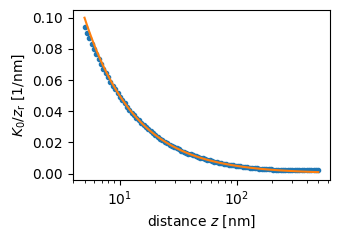

In [207]:
_, sample3_jit_A, rj_A = III_vs_z(z, 100)

We *do not* see the expected image potential with $z_{\mathrm{r}} = 10 \: \mathrm{nm}$. 

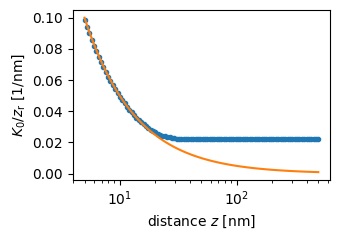

In [208]:
_, sample3_jit_B, rj_B = III_vs_z(z, 10)

... or with $z_{\mathrm{r}} = 3 \: \mathrm{nm}$. 

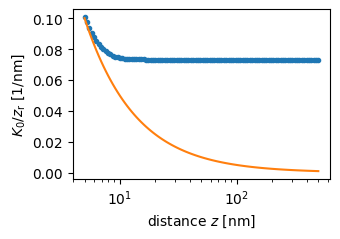

In [209]:
_, sample3_jit_C, rj_C = III_vs_z(z, 3)

**$K_0$ computed from `KmatrixIII_jit` IS NOT giving the expected image potential.**

Now let's look at the integrand in these cases.

In [223]:
def examine(sample3_jit, rj, indices):

    with plt.style.context('seaborn-v0_8'):
        
        y_array = np.logspace(np.log10(0.01), np.log10(100), 250)
        
        N = len(indices)
        fig, axs = plt.subplots(1, N, figsize=(2.0 * N, 2.5))

        for counter, n in enumerate(indices):
            
            axs[counter].set_title("r({:d}) = [{:0.1f},{:0.1f},{:0.1f}] nm".format(n, rj[n][0]/1e-9, rj[n][1]/1e-9, rj[n][2]/1e-9), fontsize=9)
            integrand = np.array([integrand3jitfast(**inputs3(sample3_jit, y, 0., rj[n], rj[n])) for y in y_array])
            for index, ls in zip([0,2,4],['-','--',':']): 
                axs[counter].loglog(y_array, np.abs(integrand[:,index]), ls, label=str(index))
            axs[counter].set_ylim([1e-4,1e2])    
            axs[counter].legend()
            

        fig.tight_layout()
        
        return fig

For $z_{\mathrm{r}} = 100 \: \mathrm{nm}$

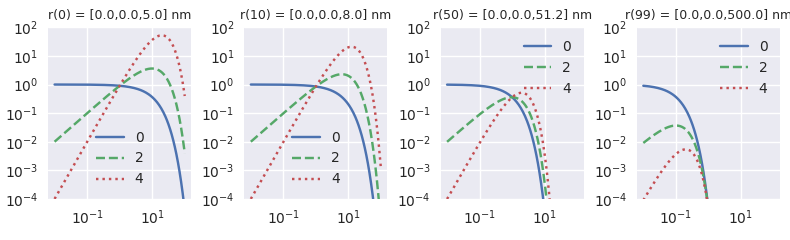

In [224]:
_ = examine(sample3_jit_A, rj_A, [0, 10, 50, 99])

For $z_{\mathrm{r}} = 10 \: \mathrm{nm}$

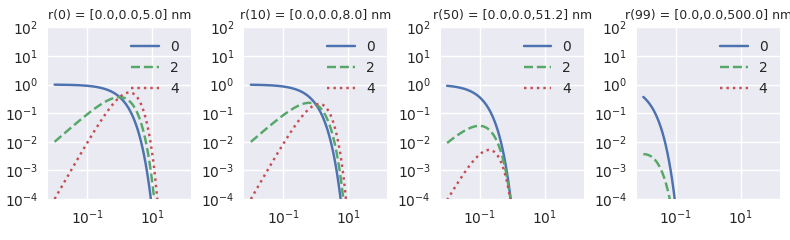

In [225]:
_ = examine(sample3_jit_B, rj_B, [0, 10, 50, 99])

For $z_{\mathrm{r}} = 3 \: \mathrm{nm}$

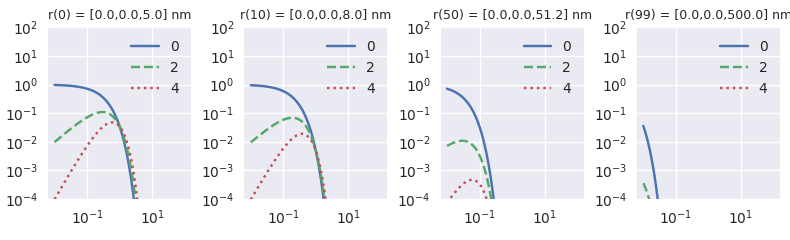

In [226]:
_ = examine(sample3_jit_C, rj_C, [0, 10, 50, 99])

Show that the integrands look the same at various heights if you change the scaling parameter.

In [249]:
def examine__new(rj, indices):

    with plt.style.context('seaborn-v0_8'):
        
        y_array = np.logspace(np.log10(0.01), np.log10(15), 250)
        
        N = len(indices)
        fig, axs = plt.subplots(1, N, figsize=(2.0 * N, 2.5))

        for counter, n in enumerate(indices):
            
            axs[counter].set_title("r({:d}) = [{:0.1f},{:0.1f},{:0.1f}] nm".format(
                n, rj[n][0]/1e-9, rj[n][1]/1e-9, rj[n][2]/1e-9), fontsize=9)

            integrand = np.zeros((len(y_array),6))
            for index, y in enumerate(y_array):
                
                inputs = inputs3(sample3_jit, y, 0., rj[n], rj[n])
                inputs['zr'] = rj[n][2] + rj[n][2]
                integrand[index,:] = integrand3jitfast(**inputs) 
            
            for index, ls in zip([0,2,4],['-','--',':']): 
                axs[counter].plot(y_array, np.abs(integrand[:,index]), ls, label=str(index)) 
            axs[counter].legend()
            
        fig.tight_layout()
        
        return fig

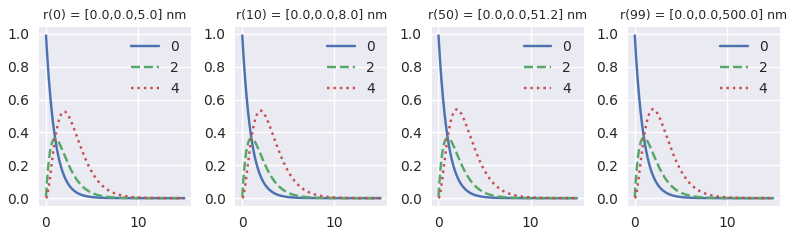

In [250]:
_ = examine__new(rj_A, [0, 10, 50, 99])

# Rewrite `KmatrixIII_jit` and try the image-charge potential again

Rewrite `KmatrixIII_jit` so that the scaling parameter `zr` changes with *every* integrand. \
Now return the **non-normalized** integrand, because now you can't just scale by a common $z_r$ after the fact.

In [299]:
@njit(parallel=True)
def KmatrixIII_jit__new(es, omega0, kD, omega, rj, rk, N, an):
    """The Green's function matrices for a Type III sample."""

    ymax = 15.    
    y = np.linspace(0., ymax, N+1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))

    K0matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K1matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K2matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    
    for k in prange(len(rk)):
        rke = rk[k]
        for j in prange(len(rj)):
            rje = rj[j]
            for m, y_ in enumerate(y):

                # ignore the input zr and set it myself
                zr = rje[2] + rke[2]
                
                result = integrand3jitfast(y_, es, zr, omega0, kD, omega, rje, rke)

                K0mat[k,j,m] = complex(result[0]/(zr * 1e9)**1, result[1]/(zr * 1e9)**1)
                K1mat[k,j,m] = complex(result[2]/(zr * 1e9)**2, result[3]/(zr * 1e9)**2)
                K2mat[k,j,m] = complex(result[4]/(zr * 1e9)**3, result[5]/(zr * 1e9)**3)

    K0matANS = dy * (an * K0mat).sum(axis=2)
    K1matANS = dy * (an * K1mat).sum(axis=2)
    K2matANS = dy * (an * K2mat).sum(axis=2)
            
    return K0matANS, K1matANS, K2matANS

In [307]:
def III_vs_z__new(z, zr):

    rj = np.array([np.zeros_like(z), np.zeros_like(z), z]).T
    
    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(3, 0), ''),   # 1e6 for metal
        sigma = ureg.Quantity(1e7, 'S/m'),   # 1e7 for metal, 1e-7 for insulator
        rho = ureg.Quantity(1e26, '1/m^3'),  # 1e26 for metal, 1e0 for insulator
        z_r = ureg.Quantity(zr, 'nm')
    )
    
    sample3_jit = SampleModel3Jit(**sample3.args())

    # Generate imputs for 
    # KmatrixIII_jit__new(es, omega0, kD, omega, rj, rk, N, an)
    
    an, _ = scipy.integrate.newton_cotes(30, 1)
    inputs = {'es': sample3_jit.epsilon_s,
              'omega0': sample3_jit.omega0,
              'kD': sample3_jit.kD,
              'omega': 0.,
              'rj': rj,
              'rk': rj,
              'N': 30,
              'an': an}
    
    K0, K1, K2 = KmatrixIII_jit__new(**inputs)

    Y = np.diag(K0).real
    Z = z / sample3_jit.z_r

    fig = plt.figure(figsize=(3.50, 2.5))
    plt.loglog(z/1e-9, Y, '.')
    plt.loglog(z/1e-9, 1/(2 * 1e9 * z), '-')
    plt.xlabel('distance $z$ [nm]')
    plt.ylabel('$K_0/z_{\mathrm{r}}$ [1/nm]')
    
    fig.tight_layout()
    
    return fig, sample3_jit, rj

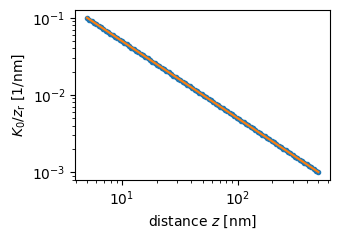

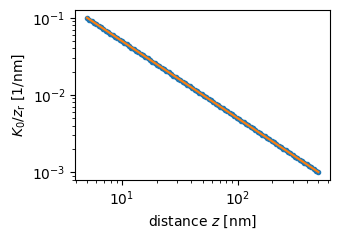

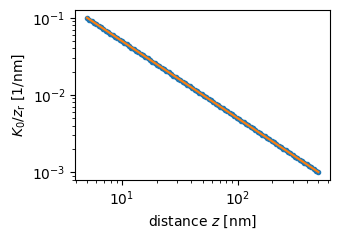

In [309]:
for zr in [100, 10, 3]:
    _, _, _ = III_vs_z__new(z, zr)

# Look at how `integrand3jitfast` behaves

(I wrote this section *before* I wrote the above code. \
 The code in this section shows good agreement between `integrand3jitfast` and `integrand3jit`. \
 In hindsight, I did not examine the integrand out to large enough distances.)

## Representative semiconductor sample

In [62]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(3, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)
sample3_jit = SampleModel3Jit(**sample3.args())

In [63]:
sample3_jit.print()

cantilever
        cantilever freq =  62000.0 Hz
                        =  389557.48904513434 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.0000000000000004e-08 m
        cone half angle =  20.0 degree
            cone length =  1.0000000000000002e-06 m

sample type =  3

semiconductor
          epsilon (real) =  3.0
          epsilon (imag) =  0.0
               thickness = infinite
            conductivity =  1e-06 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  1.0000000000000001e-07 m
 
      roll-off frequency =  112940.9067373019 Hz
    inverse Debye length =  26456583.416667342 m^{{-1}}
            Debye length =  3.7797775481848936e-08 m


In [70]:
inputs = inputs3(sample3_jit, 2., 1.0e5, rj[0], rk[0])
inputs

{'y': 2.0,
 'es': (20+0j),
 'zr': 1.0000000000000001e-07,
 'omega0': 1.129409067373019e+18,
 'kD': 8366306270.290836,
 'omega': 100000.0,
 'location1': array([0.0e+00, 0.0e+00, 5.3e-08]),
 'location2': array([1.8369702e-24, 0.0000000e+00, 5.0000000e-08])}

In [71]:
r1 = integrand3jitfast(**inputs)
r1

array([ 1.27317792e-01, -2.21844019e-14,  2.54635583e-01, -4.43688039e-14,
        5.09271167e-01, -8.87376077e-14])

In [81]:
r2 = integrand3jit(inputs['y'], sample3_jit, inputs['omega'], inputs['location1'], inputs['location2'])
r2

array([ 1.27317792e-01, -2.21844019e-14,  2.54635583e-01, -4.43688039e-14,
        5.09271167e-01, -8.87376077e-14])

In [82]:
compare(r1, r2) 

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.1273178 +0.1273178 +0.0e+00 +0.000
1 -0.0000000 -0.0000000 -0.0e+00 -0.000
2 +0.2546356 +0.2546356 +0.0e+00 +0.000
3 -0.0000000 -0.0000000 -0.0e+00 -0.000
4 +0.5092712 +0.5092712 +0.0e+00 +0.000
5 -0.0000000 -0.0000000 -0.0e+00 -0.000


The integrand function `integrand3jitfast` seems to be behaving ok.

Test one $K_n$ matrix element computed using the `KmatrixIII_jit` function.  It looks good.

In [102]:
r3 = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[0], rk[0])) 

K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, inputs['omega'], rj, rk))
r4 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

compare(r3,r4)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.9703702 +0.9703702 +1.4e-08 +0.000
1 -0.0000000 -0.0000000 +1.3e-08 +0.000
2 +0.9416185 +0.9416183 +1.6e-07 +0.000
3 -0.0000000 -0.0000000 +1.7e-07 +0.000
4 +1.8274374 +1.8274376 -6.5e-08 -0.000
5 -0.0000000 -0.0000000 -1.4e-07 -0.000


Test another $K_n$ matrix element computed using the `KmatrixIII_jit` function.  It also looks good.

In [111]:
r5 = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[3], rk[7])) 

K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, inputs['omega'], rj, rk))
r6 = disentangle(np.array([K0[7][3], K1[7][3], K2[7][3]]))

compare(r5,r6)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.7479187 +0.7479186 +1.6e-07 +0.000
1 -0.0000000 -0.0000000 +1.8e-07 +0.000
2 +0.5480898 +0.5480910 -2.2e-06 -0.000
3 -0.0000000 -0.0000000 -2.4e-06 -0.000
4 +0.7865807 +0.7865724 +1.1e-05 +0.001
5 -0.0000000 -0.0000000 +1.1e-05 +0.001


## Representative metal sample

In [113]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e7, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)
sample3_jit = SampleModel3Jit(**sample3.args())

In [114]:
r1 = integrand3jitfast(**inputs)
r1

array([ 1.27317792e-01, -2.21844019e-14,  2.54635583e-01, -4.43688039e-14,
        5.09271167e-01, -8.87376077e-14])

In [115]:
r2 = integrand3jit(inputs['y'], sample3_jit, inputs['omega'], inputs['location1'], inputs['location2'])
r2

array([ 1.27317792e-01, -2.21844019e-14,  2.54635583e-01, -4.43688039e-14,
        5.09271167e-01, -8.87376077e-14])

In [116]:
compare(r1, r2)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.1273178 +0.1273178 +0.0e+00 +0.000
1 -0.0000000 -0.0000000 -0.0e+00 -0.000
2 +0.2546356 +0.2546356 +0.0e+00 +0.000
3 -0.0000000 -0.0000000 -0.0e+00 -0.000
4 +0.5092712 +0.5092712 +0.0e+00 +0.000
5 -0.0000000 -0.0000000 -0.0e+00 -0.000


Test one $K_n$ matrix element computed using the `KmatrixIII_jit` function.  It looks good.

In [117]:
r3 = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[0], rk[0])) 

K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, inputs['omega'], rj, rk))
r4 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

compare(r3,r4)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.9703702 +0.9703702 +1.4e-08 +0.000
1 -0.0000000 -0.0000000 +1.3e-08 +0.000
2 +0.9416185 +0.9416183 +1.6e-07 +0.000
3 -0.0000000 -0.0000000 +1.7e-07 +0.000
4 +1.8274374 +1.8274376 -6.5e-08 -0.000
5 -0.0000000 -0.0000000 -1.4e-07 -0.000


Test another $K_n$ matrix element computed using the `KmatrixIII_jit` function.  It also looks good.

In [118]:
r5 = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[3], rk[7])) 

K0, K1, K2 = KmatrixIII_jit(**inputsIII(sample3_jit, inputs['omega'], rj, rk))
r6 = disentangle(np.array([K0[7][3], K1[7][3], K2[7][3]]))

compare(r5,r6)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.7479187 +0.7479186 +1.6e-07 +0.000
1 -0.0000000 -0.0000000 +1.8e-07 +0.000
2 +0.5480898 +0.5480910 -2.2e-06 -0.000
3 -0.0000000 -0.0000000 -2.4e-06 -0.000
4 +0.7865807 +0.7865724 +1.1e-05 +0.001
5 -0.0000000 -0.0000000 +1.1e-05 +0.001


**In summary, the `KmatrixIII_jit` seems to be producting accurate matrix elements, when compared to `K_jit`.**

# New `twodimCobject` object

This is code copied from `dissipation9c.py` that I could edit (but didn't edit it).

In [193]:
@jit(nopython=True)
def KmatrixIII_jit(es, zr, omega0, kD, omega, rj, rk, N, an):
    """The Green's function matrices for a Type III sample."""
    
    ymax = 30.    
    y = np.linspace(0., ymax, N+1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))

    K0matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K1matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K2matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                
                result = integrand3jitfast(y_, es, zr, omega0, kD, omega, rje, rke)

                K0mat[k,j,m] = complex(result[0], result[1])
                K1mat[k,j,m] = complex(result[2], result[3])
                K2mat[k,j,m] = complex(result[4], result[5])

    K0matANS = dy * (an * K0mat).sum(axis=2)
    K1matANS = dy * (an * K1mat).sum(axis=2)
    K2matANS = dy * (an * K2mat).sum(axis=2)
            
    return K0matANS, K1matANS, K2matANS

Copy the `dissuipation8c.py` code but edit `.solve`.

In [221]:
class twodimCobject():

    def __init__(self, sample):
        """Here sample is a SampleModel1Jit, SampleModel2Jit, 
        SampleModel3Jit, or SampleModel4Jit object."""

        self.sample = sample

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(sample.z_r, 'm')
        
    @property
    def cG(self):
        return (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
    
    @property
    def cGinv(self):
        return 1/self.cG

    def addsphere(self, h, N, M, theta_start=-np.pi/2, theta_stop=3*np.pi/2, theta_endpoint=False):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: 
        (a) self.rk, the voltage-test points, and (b) self.rj, the image-charge
        points, with the coordinates in nanometers. 
        """

        # update
        self.zr = h.to('m')
        
        # read from sample.cantilever object
        r = ureg.Quantity(self.sample.cantilever.R, 'm').to('nm').magnitude

        # convert to nm and strip units
        h = h.to('nm').magnitude
        
        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rj = np.array([[0, 0, h + r + r * delta] for  delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=theta_start, stop=theta_stop, endpoint=theta_endpoint, num=M)
        self.rk = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'N': N,
                     'M': M }

        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}  

    def plot(self, N=0, M=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if N == 0:
            N = self.info['N']

        if M == 0:
            M = self.info['M']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rj[0:N,0], self.rj[0:N,2], 
            marker='.', c=self.results['q'][0:N], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:N])), 
            vmax=max(abs(self.results['q'][0:N])))
        ax1.scatter(self.rk[0:M,0], self.rk[0:M,2], marker='.')
        ax1.set_xlabel('$x$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rj[0:N,2], self.results['q'][0:N], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)

        V = self.results['V'][0:M]
        ax3.plot(1e6 * (V - np.ones_like(V)), '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$\delta V/V_0$ [ppm]')
        
        ax4.plot(self.results['S'][0:N], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:N], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig
        
    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """
        
        ## START new
        
        # Distances in meter not nanometer
        rj = self.rj * 1e-9
        rk = self.rk * 1e-9
        
        # Normalized distances to fed to the Coulomb matrix function
        Rj = rj / self.zr.to('meter').magnitude
        Rk = rk / self.zr.to('meter').magnitude

        Cmat = Cmatrix_jit(Rj, Rk)

        # make sure this is up to date
        self.sample.z_r = self.zr.to('m').magnitude 
        
        if self.sample.type == 4:
            
            K0, K1, K2 = KmatrixIV_jit(self.sample, rj, rk)

        elif self.sample.type == 3:

            K0, K1, K2 = KmatrixIII_jit(**inputsIII(self.sample, omega, rj, rk))
        
        G0 = Cmat - K0

        ## END new
        
        U, S, VT = np.linalg.svd(G0, full_matrices=False)
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q
  
        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr

        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr

        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        self.L0 = L0
        self.L1 = L1
        self.L2 = L2

        return L0, L1, L2

    def properties(self):

        # Lambda values at 0 frequency and the cantilever frequency
        
        L0dc, L1dc, L2dc = self.solve(0.)
        L0ac, L1ac, L2ac = self.solve(self.sample.cantilever.omega_c)

        for key, val in zip(
            ['L0dc', 'L1dc', 'L2dc', 'L0ac', 'L1ac', 'L2ac'],
            [L0dc, L1dc, L2dc, L0ac, L1ac, L2ac]):

            self.results[key] = val

        # Capacitance and derivatives
        
        c0 = self.cGinv * (qe / self.Vr)
        C0 = (c0 / self.zr**0) * np.imag(complex(0,1) * L0dc) 
        C1 = (c0 / self.zr**1) * np.imag(complex(0,1) * L1dc) 
        C2 = (c0 / self.zr**2) * np.imag(complex(0,1) * L2dc)
        
        for key, values, unit in zip(
            ['C0 [aF]', 'C1 [pF/m]', 'C2 [mF/m^2]'],
            [C0, C1, C2],
            ['aF', 'pF/m', 'mF/m^2']):

            self.results[key] = values.to(unit).magnitude        

## Metal (Type IV sample)

Run the code on a metal sample first.

In [222]:
(4 * np.pi * epsilon0 *  cantilever.R).to('aF')

<Quantity(3.337950166343611, 'attofarad')>

In [223]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(10, 'nm'))

sample4_jit = SampleModel4Jit(**sample4.args())

In [224]:
obj['IVb'] = twodimCobject(sample4_jit)

In [293]:
params = {'h': ureg.Quantity(10, 'nm'), 
          'N': 15, 
          'M': 20, 
          'theta_stop': np.pi/2, 
          'theta_endpoint': True}

obj['IVb'].addsphere(**params)

(5.0168659740837525+0j) (-1.0698299473824462+0j) (1.3354958005593673+0j)


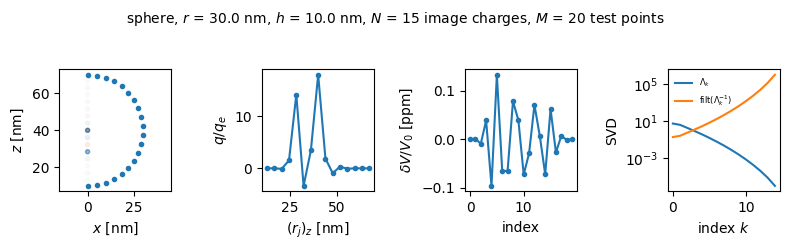

In [311]:
L0, L1, L2 = obj['IVb'].solve(0.)
print(L0, L1, L2)
_ = obj['IVb'].plot()

In [295]:
obj['IVb'].properties()
obj['IVb'].results['C0 [aF]']

5.582016204238822

Compute the capacitance and its derivatives versus height.

In [296]:
def CtableMetal(sample, h_array):
    
    obj = {}
    
    for index, h in enumerate(h_array):

        obj[index] = twodimCobject(sample)

        params = {'h': h,
                  'N': 15,
                  'M': 20,
                  'theta_stop': np.pi/2, 
                  'theta_endpoint': True}
          
        obj[index].addsphere(**params)
        obj[index].properties()

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h [nm]']
        
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = Csphere(
                order, 
                ureg.Quantity(np.array([obj[index].info['h [nm]']]), 'nm'), 
                ureg.Quantity(obj[index].info['r [nm]'], 'nm'))[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]

    # Bold the error columns 

    def bold_column_elements(s):
        return ['font-weight: bold' 
            if ((s.name == 'err0 [ppm]') or (s.name == 'err1 [ppm]') or (s.name == 'err2 [ppm]')) 
            else '' for _ in s]

    df = df.style.apply(bold_column_elements, axis=0)
    
    return df

In [297]:
h_array = ureg.Quantity(
    np.logspace(
        start=np.log10(10e-9),
        stop=np.log10(1e-6),
        num=21,
        endpoint=True), 
    'm')

df = CtableMetal(sample4_jit, h_array)
df

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,10.000000,5.582016,5.582016,0.110416,-119.034635,-119.034164,3.958283,14.859395,14.859012,25.747426
1,12.589254,5.316010,5.316010,0.017375,-88.893624,-88.893558,0.748455,9.098126,9.098079,5.193297
2,15.848932,5.067109,5.067109,0.001292,-65.739113,-65.739106,0.107766,5.529873,5.529868,0.886660
3,19.952623,4.836591,4.836591,-0.000468,-48.093934,-48.093934,0.000713,3.331558,3.331558,0.100184
4,25.118864,4.625488,4.625488,-0.000207,-34.775222,-34.775223,-0.008427,1.986364,1.986364,-0.016815
5,31.622777,4.434486,4.434486,0.000053,-24.833754,-24.833755,-0.003549,1.170195,1.170195,-0.018340
6,39.810717,4.263851,4.263851,0.000095,-17.506742,-17.506742,0.000220,0.680174,0.680174,-0.006522
7,50.118723,4.113378,4.113378,0.000092,-12.181622,-12.181622,0.001524,0.389639,0.389639,0.000564
8,63.095734,3.982391,3.982391,0.000060,-8.368576,-8.368576,0.001397,0.219844,0.219844,0.002744
9,79.432823,3.869782,3.869782,0.000017,-5.679518,-5.679518,0.000768,0.122166,0.122166,0.002286


## Semi-infinite dielectric (Type III sample)

Now run the code on a semi-infinite dielectric.  Create a new `sample3` with essentially zero charge density and low conductivity.

In [312]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(3, 0), ''),   # 1e6 for metal
    sigma = ureg.Quantity(1e7, 'S/m'),   # 1e7 for metal, 1e-7 for insulator
    rho = ureg.Quantity(1e26, '1/m^3'),  # 1e26 for metal, 1e0 for insulator
    z_r = ureg.Quantity(10, 'nm')
)

sample3_jit = SampleModel3Jit(**sample3.args())

In [313]:
obj['IIIb'] = twodimCobject(sample3_jit)

params = {'h': ureg.Quantity(10, 'nm'), 
          'N': 15, 
          'M': 20, 
          'theta_stop': np.pi/2, 
          'theta_endpoint': True}

obj['IIIb'].addsphere(**params)

(8.884935622745818+0j) (-0.2051158941253542+0j) (0.5719574175902221+0j)


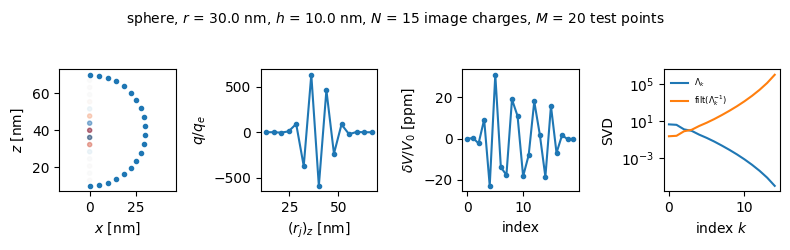

In [314]:
L0, L1, L2 = obj['IIIb'].solve(0.)
print(L0, L1, L2)
_ = obj['IIIb'].plot()

In [315]:
obj['IIIb'].properties()
obj['IIIb'].results['C0 [aF]']

9.885824113298893

This code is essentially the same as for a metal, except it calls `CsphereOverSemi` instead of `Csphere`. 

In [302]:
def CtableDielectric(sample, h_array):
    
    obj = {}
    
    for index, h in enumerate(h_array):

        sample.z_r = h.to('m').magnitude
        
        obj[index] = twodimCobject(sample)

        params = {'h': h,
                  'N': 15,
                  'M': 20,
                  'theta_stop': np.pi/2, 
                  'theta_endpoint': False}
        
        obj[index].addsphere(**params)
        obj[index].properties()

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h [nm]']
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = CsphereOverSemi(
                order, 
                ureg.Quantity(np.array([obj[index].info['h [nm]']]), 'nm'), 
                ureg.Quantity(obj[index].info['r [nm]'], 'nm'),
                sample.epsilon_s.real)[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]

    # Bold the error columns 

    def bold_column_elements(s):
        return ['font-weight: bold' 
            if ((s.name == 'err0 [ppm]') or (s.name == 'err1 [ppm]') or (s.name == 'err2 [ppm]')) 
            else '' for _ in s]

    df = df.style.apply(bold_column_elements, axis=0)
    
    return df

In [303]:
df = CtableDielectric(sample3_jit, h_array)
df

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,10.000000,9.834781,4.139892,1375612.765019,-9.556734,-27.760375,-655741.896762,2.280524,2.139704,65812.901533
1,12.589254,7.065294,4.074468,734040.668777,-10.239790,-23.021487,-555207.284763,1.873994,1.564988,197449.703971
2,15.848932,5.796882,4.006845,446744.977951,-11.073644,-18.712187,-408212.206957,1.558963,1.115716,397275.685523
3,19.952623,5.090973,3.938365,292661.581127,-11.113700,-14.894488,-253838.010247,1.197103,0.774437,545772.520806
4,25.118864,4.651380,3.870475,201759.670642,-10.186142,-11.603025,-122113.264042,0.833074,0.522833,593385.717256
5,31.622777,4.354443,3.804611,144517.144343,-8.590531,-8.843874,-28646.138705,0.532046,0.343046,550945.404737
6,39.810717,4.140590,3.742089,106491.613350,-6.770150,-6.596286,26357.835738,0.319143,0.218681,459400.053903
7,50.118723,3.978965,3.683994,80068.393496,-5.067148,-4.817252,51875.076527,0.183923,0.135470,357661.772789
8,63.095734,3.852771,3.631112,61044.479196,-3.651227,-3.448212,58875.449702,0.103525,0.081628,268260.437942
9,79.432823,3.752303,3.583896,46989.678410,-2.558745,-2.422721,56145.156765,0.057424,0.047914,198496.180004


Why is this calculation failing?

**The $K_n$ integrals can be computed using the Newton-Cotes algorithm, but *every point* needs to be scaled differently.**

**I need to back to paper-and-pencil math and rewrite it to allow for point-by-point scaling of the integral.**

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-54.ipynb && open dissipation-theory--Study-54.html
    
:::